<a href="https://colab.research.google.com/github/ghassantaleb/loyalty-landscape-analysis/blob/main/loyalty_landscape_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd

data = pd.read_csv('/content/marketing_campaign.csv', delimiter='\t')

data.head()

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [6]:
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'], format='%d-%m-%Y')


In [7]:
import datetime

current_date = datetime.datetime.now()
data['Customer_Tenure'] = (current_date - data['Dt_Customer']).dt.days


In [8]:
# Assign the filled 'Income' column back to the DataFrame
data['Income'] = data['Income'].fillna(data['Income'].median())


In [9]:
data.isnull().sum()  # Check for remaining missing values


,0
ID,0
Year_Birth,0
Education,0
Marital_Status,0
Income,0
Kidhome,0
Teenhome,0
Dt_Customer,0
Recency,0
MntWines,0


In [10]:
from sklearn.preprocessing import StandardScaler

# Create a scaler object
scaler = StandardScaler()

# Scale continuous variables
data[['Income', 'MntWines', 'MntMeatProducts']] = scaler.fit_transform(data[['Income', 'MntWines', 'MntMeatProducts']])

In [36]:

# Recency: Calculate days since the last purchase
# Assuming today is the reference point for calculating recency
import datetime
today = datetime.datetime.now()

# Group by customer ID and calculate metrics
rm = data.groupby('ID').agg({
    'Dt_Customer': lambda x: (today - x.max()).days,  # Recency: days since last purchase
    'MntWines': 'sum',  # Monetary: sum of MntWines (or your chosen monetary metric)
})

# Rename columns for clarity
rm = rm.rename(columns={'Dt_Customer': 'Recency', 'MntWines': 'Monetary'})
rm = rm.reset_index()

# Renaming columns for clarity
rm.columns = ['CustomerID', 'Recency', 'Monetary']
rm.head()

,CustomerID,Recency,Monetary
0,0,4195,-0.192961
1,1,3788,0.475643
2,9,4454,-0.733787
3,13,4116,-0.846707
4,17,4070,0.989724


In [38]:
# Assign scores from 1 to 5 for each RM metric (higher is better)
rm['Recency_Score'] = pd.qcut(rm['Recency'], 5, labels=[5, 4, 3, 2, 1])
rm['Monetary_Score'] = pd.qcut(rm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# Create an overall RM score
rm['RM_Score'] = rm['Recency_Score'].astype(str) + rm['Monetary_Score'].astype(str)

rm.head()


,CustomerID,Recency,Monetary,Recency_Score,Monetary_Score,RM_Score
0,0,4195,-0.192961,3,3,33
1,1,3788,0.475643,5,4,54
2,9,4454,-0.733787,1,2,12
3,13,4116,-0.846707,3,2,32
4,17,4070,0.989724,3,5,35


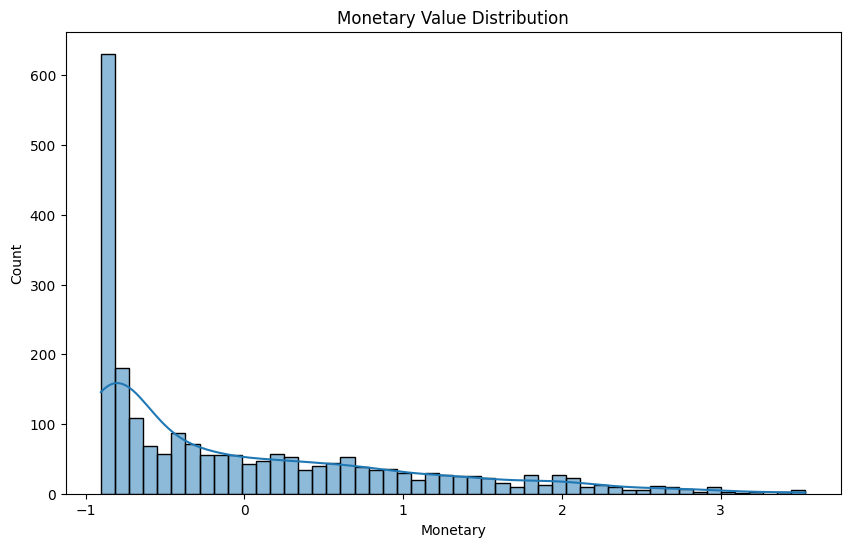

In [39]:
# Check the distribution of Monetary values
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(rfm['Monetary'], bins=50, kde=True)
plt.title('Monetary Value Distribution')
plt.show()


In [42]:
# Define a function to classify customers into loyalty segments based on RM scores
def loyalty_segment_rm(df):
    if df['RM_Score'] in ['55', '54', '45', '44']:  # High Recency and Monetary
        return 'Champion'
    elif df['RM_Score'] in ['53', '52', '43', '42', '35', '34', '33']:  # Moderate Recency and Monetary
        return 'Loyal Customer'
    elif df['RM_Score'] in ['51', '41', '32', '31', '25', '24', '23', '22']:  # Recent but low Monetary or vice versa
        return 'Potential Loyalist'
    elif df['RM_Score'] in ['21', '15', '14', '13', '12']:  # Low Recency or Low Monetary
        return 'At Risk'
    else:
        return 'Lost Customer'  # Very low Recency and Monetary

# Apply the function to classify each customer
rm['Segment'] = rm.apply(loyalty_segment_rm, axis=1)

# Display the segmentation results
segment_counts = rm['Segment'].value_counts()
rm.head(), segment_counts



(   CustomerID  Recency  Monetary Recency_Score Monetary_Score RM_Score  \
 0           0     4195 -0.192961             3              3       33   
 1           1     3788  0.475643             5              4       54   
 2           9     4454 -0.733787             1              2       12   
 3          13     4116 -0.846707             3              2       32   
 4          17     4070  0.989724             3              5       35   
 
               Segment  
 0      Loyal Customer  
 1            Champion  
 2             At Risk  
 3  Potential Loyalist  
 4      Loyal Customer  ,
 Segment
 Potential Loyalist    752
 Loyal Customer        649
 At Risk               460
 Champion              307
 Lost Customer          72
 Name: count, dtype: int64)

<ipython-input-43-326ecc136baa>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Segment', data=rm, order=rm['Segment'].value_counts().index, palette='viridis')


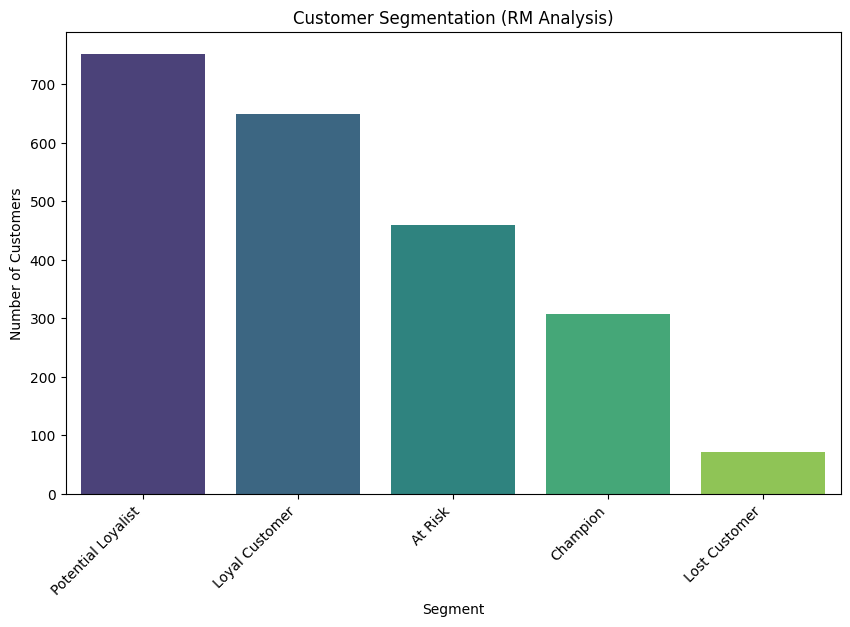

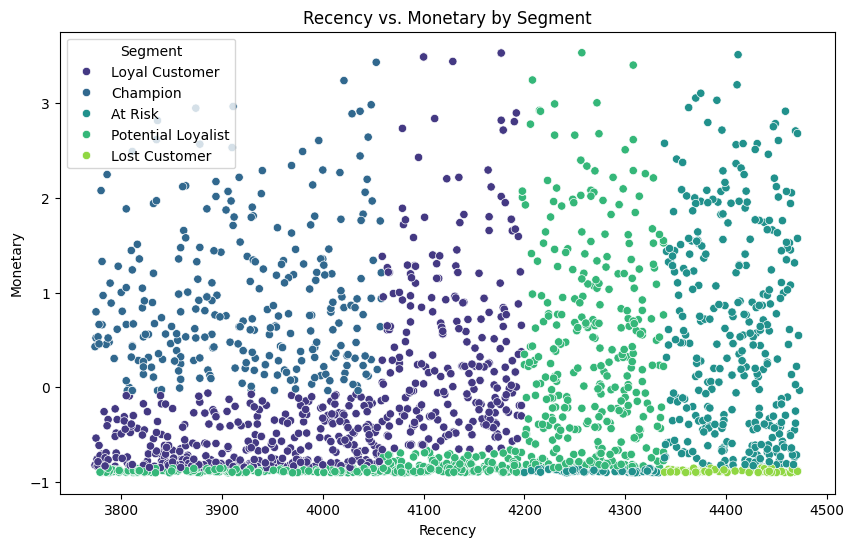

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of segments
plt.figure(figsize=(10, 6))
sns.countplot(x='Segment', data=rm, order=rm['Segment'].value_counts().index, palette='viridis')
plt.title('Customer Segmentation (RM Analysis)')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

# Optional: Plot Recency vs. Monetary with segment colors
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency', y='Monetary', hue='Segment', data=rm, palette='viridis')
plt.title('Recency vs. Monetary by Segment')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.show()

In [44]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select the features for clustering (Recency and Monetary)
X = rm[['Recency', 'Monetary']]

# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

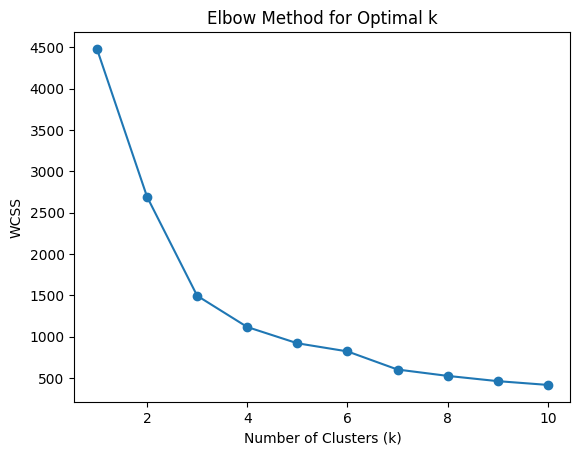

In [45]:
import matplotlib.pyplot as plt

wcss = []  # Within-cluster sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()

In [53]:
k = 3

kmeans_k3 = KMeans(n_clusters=k, random_state=42)
rm_k3 = rm.copy()  # Create a copy of 'rm' for k=3
rm_k3['Cluster'] = kmeans_k3.fit_predict(X_scaled)

             Recency  Monetary
Cluster                       
0        4288.577215 -0.487166
1        3945.430429 -0.642333
2        4324.430233  1.567401
3        3964.890208  1.007801


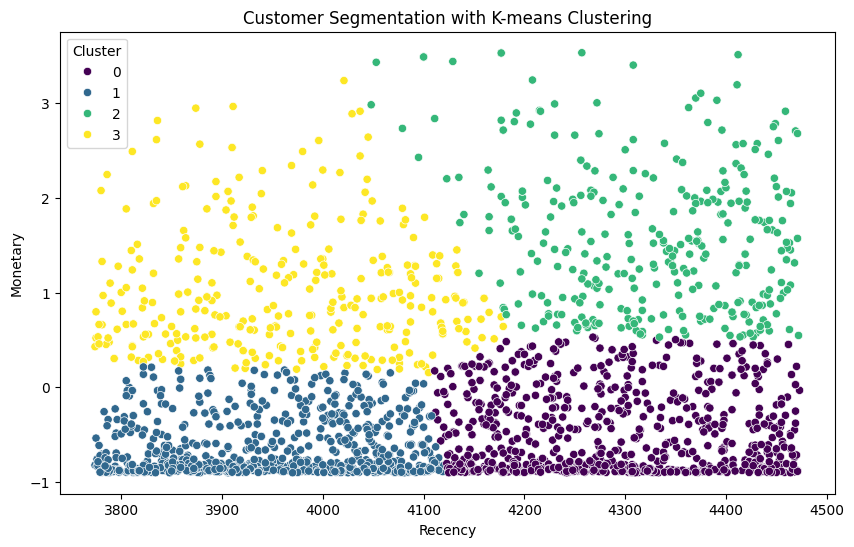

In [54]:
# Analyze cluster characteristics (e.g., mean Recency and Monetary for each cluster)
cluster_means = rm.groupby('Cluster')[['Recency', 'Monetary']].mean()
print(cluster_means)

# Visualize the clusters (e.g., scatter plot of Recency vs. Monetary with cluster colors)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency', y='Monetary', hue='Cluster', data=rm, palette='viridis')
plt.title('Customer Segmentation with K-means Clustering')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.show()

In [55]:
k = 4

kmeans_k4 = KMeans(n_clusters=k, random_state=42)
rm_k4 = rm.copy()  # Create a copy of 'rm' for k=4
rm_k4['Cluster'] = kmeans_k4.fit_predict(X_scaled)

             Recency  Monetary
Cluster                       
0        4288.577215 -0.487166
1        3945.430429 -0.642333
2        4324.430233  1.567401
3        3964.890208  1.007801


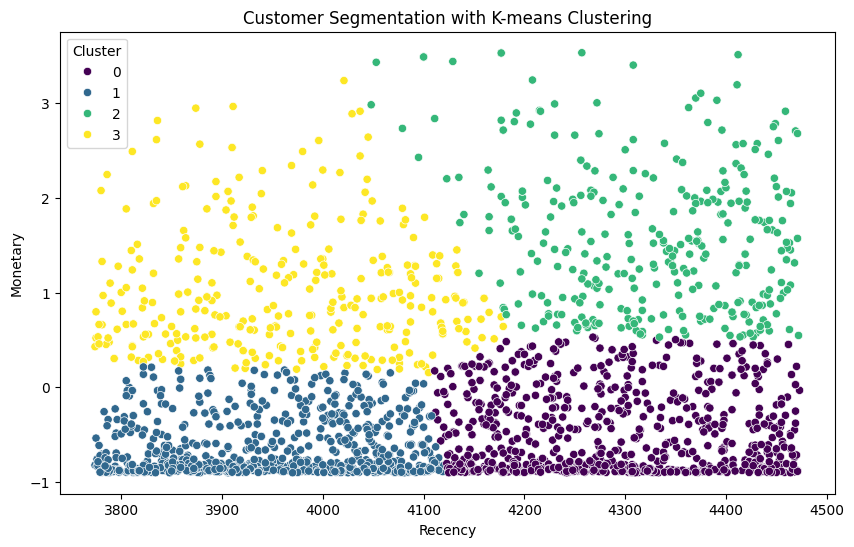

In [56]:
# Analyze cluster characteristics (e.g., mean Recency and Monetary for each cluster)
cluster_means = rm.groupby('Cluster')[['Recency', 'Monetary']].mean()
print(cluster_means)

# Visualize the clusters (e.g., scatter plot of Recency vs. Monetary with cluster colors)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency', y='Monetary', hue='Cluster', data=rm, palette='viridis')
plt.title('Customer Segmentation with K-means Clustering')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.show()

Cluster Means (k=3):
              Recency  Monetary
Cluster                       
0        4290.991463 -0.458326
1        3938.491909 -0.427940
2        4211.336714  1.566993

Cluster Means (k=4):
              Recency  Monetary
Cluster                       
0        4288.577215 -0.487166
1        3945.430429 -0.642333
2        4324.430233  1.567401
3        3964.890208  1.007801

Inertia (k=3): 1494.8683266083642
Inertia (k=4): 1116.7274012129203

Silhouette Score (k=3): 0.4402836872922803
Silhouette Score (k=4): 0.4448616203729451


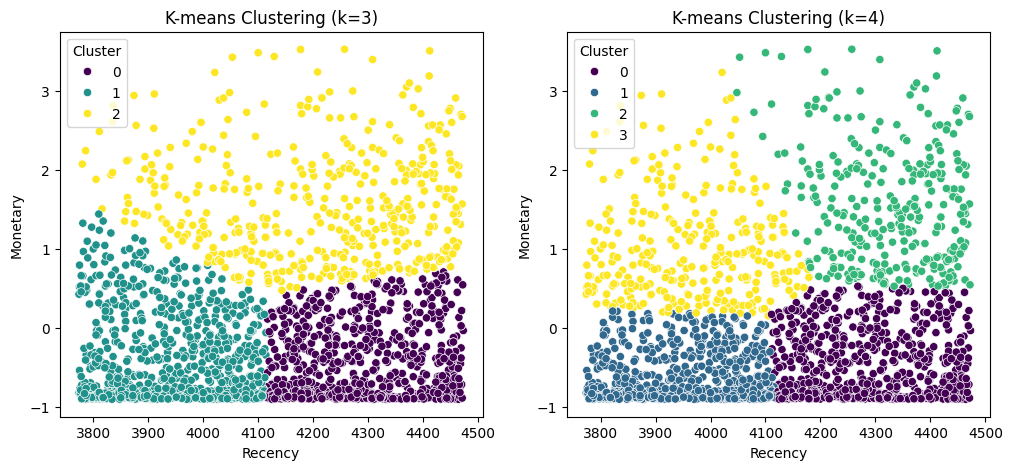

In [57]:
# Calculate and compare cluster characteristics
cluster_means_k3 = rm_k3.groupby('Cluster')[['Recency', 'Monetary']].mean()
cluster_means_k4 = rm_k4.groupby('Cluster')[['Recency', 'Monetary']].mean()
print("Cluster Means (k=3):\n", cluster_means_k3)
print("\nCluster Means (k=4):\n", cluster_means_k4)

# Calculate and compare internal evaluation metrics
inertia_k3 = kmeans_k3.inertia_  # Assuming 'kmeans_k3' is your KMeans object for k=3
inertia_k4 = kmeans_k4.inertia_  # Assuming 'kmeans_k4' is your KMeans object for k=4
print("\nInertia (k=3):", inertia_k3)
print("Inertia (k=4):", inertia_k4)

from sklearn.metrics import silhouette_score
silhouette_k3 = silhouette_score(X_scaled, rm_k3['Cluster'])
silhouette_k4 = silhouette_score(X_scaled, rm_k4['Cluster'])
print("\nSilhouette Score (k=3):", silhouette_k3)
print("Silhouette Score (k=4):", silhouette_k4)

# Visualize the clusters
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='Recency', y='Monetary', hue='Cluster', data=rm_k3, palette='viridis')
plt.title('K-means Clustering (k=3)')
plt.subplot(1, 2, 2)
sns.scatterplot(x='Recency', y='Monetary', hue='Cluster', data=rm_k4, palette='viridis')
plt.title('K-means Clustering (k=4)')
plt.show()